# Adaboost.R2 (Drucker, 1997) implementation

## Introduction 
### Goal of the notebook
The idea is to present a flexible class to implement adaboost.R2 ([Drucker 1997](https://www.researchgate.net/publication/2424244_Improving_Regressors_Using_Boosting_Techniques)) on python. This class allows you to adjust hyperparameters of the algorithm (number of boosts, type of loss, the regressor you want to use, and its propers arguments)



## Class implementation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

class data():
    """
    Creates a data object ready to input our algorithm 
    (features and labels normalized etc) 
    """
    def __init__(self, df, features, labels):
        """
        Instantiates the data object
        args: 
            df (pd.dataframe) : The dataframe containing the data 
            features (list like) : The features of the dataframe
            label (str) : The label (continuous) of your problem
        """
        df = self.get_dummies(self.normalize_data(df)) # It is not necessary to normalize the features but it is a good practice to have (it can accelerate the convergence of some algorithm)
        self.X = np.array(df.loc[:,features])
        self.y = np.array(df.loc[:,[labels]])
    
    def normalize_data(self, df):       

        """
        Normalizes the numeric variables to be between 0 and 1
        args: 
            df (pd.dataframe) : The dataframe to normalize
        returns:
            df (pd.dataframe) : The normalized dataframe  
        """
        
        numeric_variables  = df.select_dtypes(include = np.number).columns
        df[numeric_variables] =  (df.loc[:,numeric_variables] - df.loc[:,numeric_variables].min()) /(df.loc[:,numeric_variables].max() - df.loc[:,numeric_variables].min())
        return(df)

    def get_dummies(self, df):
        """
        Get dummy variables for the categorical data
        args: 
            df (pd.dataframe) : The dataframe to normalize
        returns:
            df (pd.dataframe) : The normalized dataframe  
        """
        df = pd.get_dummies(df)
        return(df)

class Adaboost_R2():
  """
  Implements the Adaboost.R2 presented by H.Drucker (1997) with a linear regression
  as weak learner (too long to implement all the regression algorithm).
  """
  def __init__(self, n_boost = 20 ,loss = "square",estimator = DecisionTreeRegressor, **kwargs):
    """ 
    Instentiate the hyper parameters of ou adaboost algorithm 
    args : 
      n_boost (int) : The number of boosting iteration to do   
      loss (string) : either 'linear', 'square' or 'exponential'
      estimator (sk_learn_estimator) : sk_learn regressor to fit
      kwargs : args for the regressors (in order to have a high biased regressor) 
    """
    self.n_boost = n_boost
    self.loss = loss
    self.estimator = estimator
    self.reg_args = kwargs
  
  def _boost(self,X,y,weights):
    """
    Performs one step of boosting
    args :
      X (list like) : features
      y (list like) : labels
      weights (list like) : weights for the training examples
    returns
      log_beta (float) : the weight of the regressor
      new_weights (list like) : new weights for the training examples
      L (float) : The loss of the regressor
      reg (sk_learn.regressor) : the fitted regressor used
    """
    
    loss_beyond_half = True
    while loss_beyond_half:
      # STEP 1 : Bootstrap the sample
      bootstrap_id= np.random.choice(
                      np.arange(X.shape[0]),
                      size= X.shape[0],
                      replace=True,
                      p=weights)
    
      
      X_new = X[bootstrap_id,:]
      y_new = y[bootstrap_id]
      
      # STEP 2 : Creates and fit a regressor
      reg = self.estimator(**self.reg_args)
      reg.fit(X_new, y_new)

      # STEP 3 : Predict the whole dataset
      y_predict = np.squeeze(reg.predict(X))

      # STEP 4 : Calculate the loss
      error_vect = np.abs(y.reshape(y_predict.shape) - y_predict)
      used_weights = weights
      used_errors = error_vect
      D = np.max(error_vect)
      
      if self.loss == 'linear':
          L = used_errors / D
      if self.loss == 'square':
          L = used_errors ** 2 / (D**2)
      elif self.loss == 'exponential':
          L = 1 - np.exp(- used_errors / D) 
      
      # STEP 5 : Calculate the average loss
      L = np.sum(used_weights * L)
      if L < 0.5:
        loss_beyond_half = False
      
      # STEP 6 : Compute beta
      beta = L/(1. - L)

      # STEP 7 : compute new weights
      weights = weights * np.power(beta,(1. - used_errors))
      new_weights = weights/np.sum(weights)
      
      log_beta = np.log(1. / beta)
    return (log_beta, new_weights, L, reg)

  def fit(self, X, y):
    """
    Fits our Adaboost R2 algortihm
    args : 
      X (list like) : The features
      y (list like) : labels
    return 
      self : the fitted Adaboost_R2 regressor
    """
    
    self.estimators = []
    self.estimator_weights = np.zeros(self.n_boost, dtype=np.float64)
    self.losses = np.ones(self.n_boost, dtype=np.float64)
   
    self.w = []
    weight = np.repeat(1,X.shape[0])/X.shape[0]
    for t in range(self.n_boost):
      self.w.append(weight)
      estimator_weight, weight, loss, reg = self._boost(X, y, weight.copy())
      self.estimator_weights[t] = estimator_weight
      self.losses[t] = loss
      self.estimators.append(reg)
    return self 
  
  def predict(self,X):
    """
    Predicts some examples X
    args :
      X (list like) : features
    returns :
      final_preds (list like) : predictions
    """
    #STEP 8 : PREDICT !!!!
    dummy_preds = np.array([est.predict(X).reshape(X.shape[0],) for est in self.estimators]).T    
    # Sort the predictions
    sorted_idx = np.argsort(dummy_preds, axis= 1)
    sorted_pred = np.sort(dummy_preds, axis = 1)
    
    # Find index of median prediction for each sample
    left_quantity = self.estimator_weights[sorted_idx]
    left_quantity = np.cumsum(left_quantity, axis = 1) # Vector/Matrix
    right_quantity = .5 * np.sum(self.estimator_weights) # Number
    median = left_quantity >= right_quantity
    median_id = median.argmax(axis=1)
    final_preds = sorted_pred[np.arange(X.shape[0]),median_id]
    return (final_preds)


## Tests and comparisons

We will test our implementation, analyse it a bit and compare the R2 with a the R2 of a classical linear regression

### Data loading

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()
bos = pd.DataFrame(np.concatenate([boston.data, boston.target.reshape(boston.target.shape[0],1)],axis = 1),columns= np.concatenate([boston.feature_names , ["TARGET"]]))
dat = data(bos,boston.feature_names,"TARGET")
X, y = dat.X, dat.y

### First result 

In [ ]:
l = LinearRegression()
l.fit(X,y)
ada = Adaboost_R2(n_boost= 50,loss = 'square', max_depth = 4)
ada.fit(X,y)
from sklearn.metrics import r2_score
print("R2 score for linear regression : {:.2f}".format(r2_score(y, l.predict(X))))
print("R2 score for adaboot.R2 : {:.2f}".format(r2_score(y, ada.predict(X))))

R2 score for linear regression : 0.74
R2 score for adaboot.R2 : 0.94


As we can see, Ada boost is able to learn more complex functional form than a basic regression algorithm (not suprising !), so it can be useful (in real cases) to choose our hyperparameters in order to not overfit the training set.  

### Weights particularity 
#### Sample weights

Text(0.5, 0.98, 'Sample weights distribution at each 10 boosts')

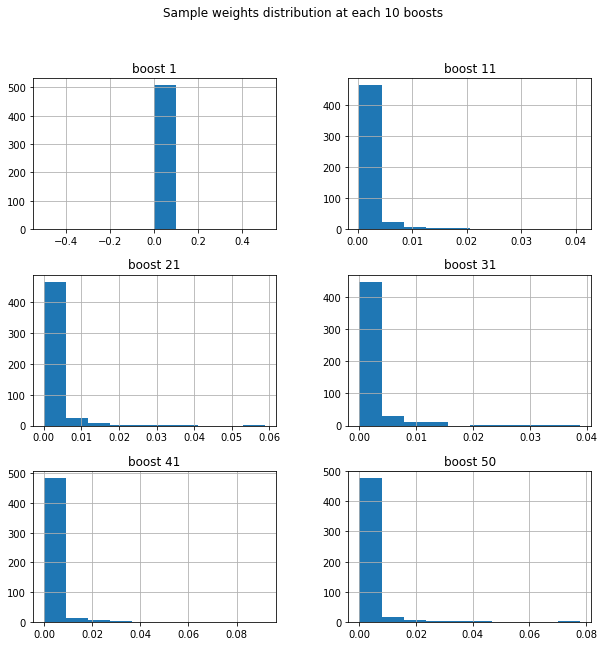

In [ ]:


w = []
c = []
for i in range(0,50,10):
  w.append(ada.w[i])
  c.append("boost " + str(i +1 ))
w.append(ada.w[-1])
c.append("boost " + str(50 ))
import pylab as pl
pd.DataFrame(np.array(w).T, columns = c).hist(figsize=(10,10))
pl.suptitle("Sample weights distribution at each 10 boosts")





As the boosts increase some samples weights are completly redistributed to increase the weight of hard to predict examples. At start each weights are equal to 0.002 and at the end some examples have weights which are equal to 0.03 (more then tens times more)   

#### Estimators weights

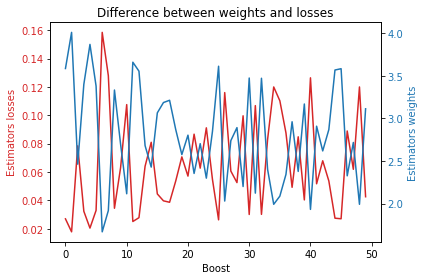

In [ ]:
# Create some mock data
data1 = ada.losses
data2 = ada.estimator_weights
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Boost')
ax1.set_ylabel('Estimators losses', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Estimators weights', color=color)  # we already handled the x-label with ax1
ax2.plot( data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Difference between weights and losses")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As we can badly see in this graph, the more the estimator loss is low, the more this estimor have weights in the final prediction.